### Data

In [14]:
#Imports
import xarray as xr
import sys
sys.path.append('/home/563/rl5183/Functions')
import model_functions as func
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import iris
import iris.analysis.stats as istats
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
func=reload(func)

In [16]:
#Historical model runs
hist_temp = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/ts/gr1.5/')
hist_precip = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/')

GISS-E2-2-G path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
45 model paths found and stored in models dictionary
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/ts/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/ts/gr1.5/v20190630/*.nc
MCM-UA-1-0 /g/data/lp01/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/ts/gr1.5/v20190731/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/ts/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historic

In [17]:
#Future model runs
future_temp = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/ts/gr1.5/')
future_precip = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/pr/gr1.5/')

MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
29 model paths found and stored in models dictionary
NESM3 /g/data/lp01/CMIP6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190728/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190924/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190119/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20191013/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190818/*.nc
BCC-CSM2-MR /g/data/lp01/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v201903

In [18]:
#Find common models between all four datasets
hist_temp = hist_temp.where(hist_temp.model.isin(hist_precip.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_temp.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_precip.model), drop = True)
hist_precip = hist_precip.where(hist_precip.model.isin(hist_temp.model), drop = True)
future_temp = future_temp.where(future_temp.model.isin(hist_temp.model), drop = True)
future_precip = future_precip.where(future_precip.model.isin(hist_temp.model), drop = True)

In [19]:
#discard models rejected by model evaluation (and extra models that have appeared) 
future_ts = future_temp.ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_ts = hist_temp.ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
future_pr = future_precip.pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_pr = hist_precip.pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])

In [20]:
#sort models alphabetically
future_ts = future_ts.sortby('model')
hist_ts = hist_ts.sortby('model')
future_pr = future_pr.sortby('model')
hist_pr = hist_pr.sortby('model')

### Mean State

In [21]:
#landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

In [22]:
future_clim = future_ts.sel(time=slice('2070-01', '2099-12'))
future_clim = future_clim - 273.15 #convert from k to c
hist_clim = hist_ts.sel(time=slice('1970-01', '1999-12'))
hist_clim = hist_clim - 273.15 #convert from k to c

In [23]:
hist_pr = hist_pr*86400
future_pr = future_pr*86400

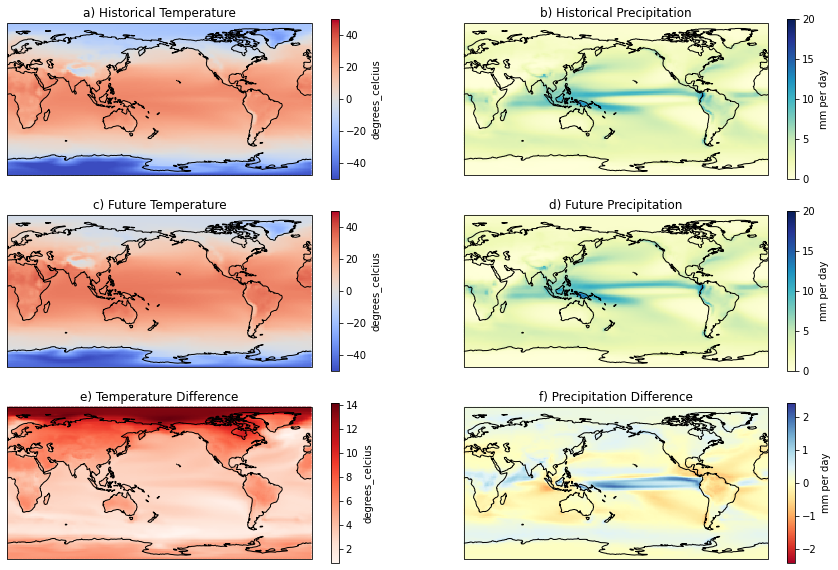

In [24]:
#historical temperature (1970-1999)
hist_temp_mmm = hist_clim.mean(dim=['model', 'time'])

#future temperature (2070-2099)
future_temp_mmm = future_clim.mean(dim=['model', 'time'])

#historical precip (1970-1999)
hist_pr_mmm = hist_pr.mean(dim=['model', 'time'])

#future precip (2070-2099)
future_pr_mmm = future_pr.mean(dim=['model', 'time'])

#calculate difference
temp_diff_mmm = future_temp_mmm - hist_temp_mmm
precip_diff_mmm = future_pr_mmm - hist_pr_mmm

fig = plt.figure(figsize=(15,10))


ax = fig.add_subplot(321, projection=ccrs.PlateCarree(180))
C = hist_temp_mmm.plot(ax=ax, vmin=-50, vmax=50, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.set_title('a) Historical Temperature')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('degrees_celcius')

ax = fig.add_subplot(322, projection=ccrs.PlateCarree(180))
C = hist_pr_mmm.plot(ax=ax, vmin=0, vmax=20, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.coastlines()
ax.set_title('b) Historical Precipitation')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('mm per day')

ax = fig.add_subplot(323, projection=ccrs.PlateCarree(180))
C = future_temp_mmm.plot(ax=ax, vmin=-50, vmax=50, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.set_title('c) Future Temperature')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('degrees_celcius')

ax = fig.add_subplot(324, projection=ccrs.PlateCarree(180))
C = future_pr_mmm.plot(ax=ax, vmin=0, vmax=20, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.coastlines()
ax.set_title('d) Future Precipitation')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('mm per day')

ax = fig.add_subplot(325, projection=ccrs.PlateCarree(180))
C = temp_diff_mmm.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='Reds')
ax.coastlines()
ax.set_title('e) Temperature Difference')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('degrees_celcius')

ax = fig.add_subplot(326, projection=ccrs.PlateCarree(180))
C = precip_diff_mmm.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
ax.coastlines()
ax.set_title('f) Precipitation Difference')
cbar = plt.colorbar(C, ax=ax,)
cbar.ax.set_ylabel('mm per day')

#plt.savefig('mean state changes mmm.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

In [25]:
future_mean_temp = future_clim.mean(dim='time')
hist_mean_temp = hist_clim.mean(dim='time')
future_mean_pr = future_pr.mean(dim='time')
hist_mean_pr = hist_pr.mean(dim='time')
temp_diff = future_mean_temp - hist_mean_temp
pr_diff = future_mean_pr - hist_mean_pr

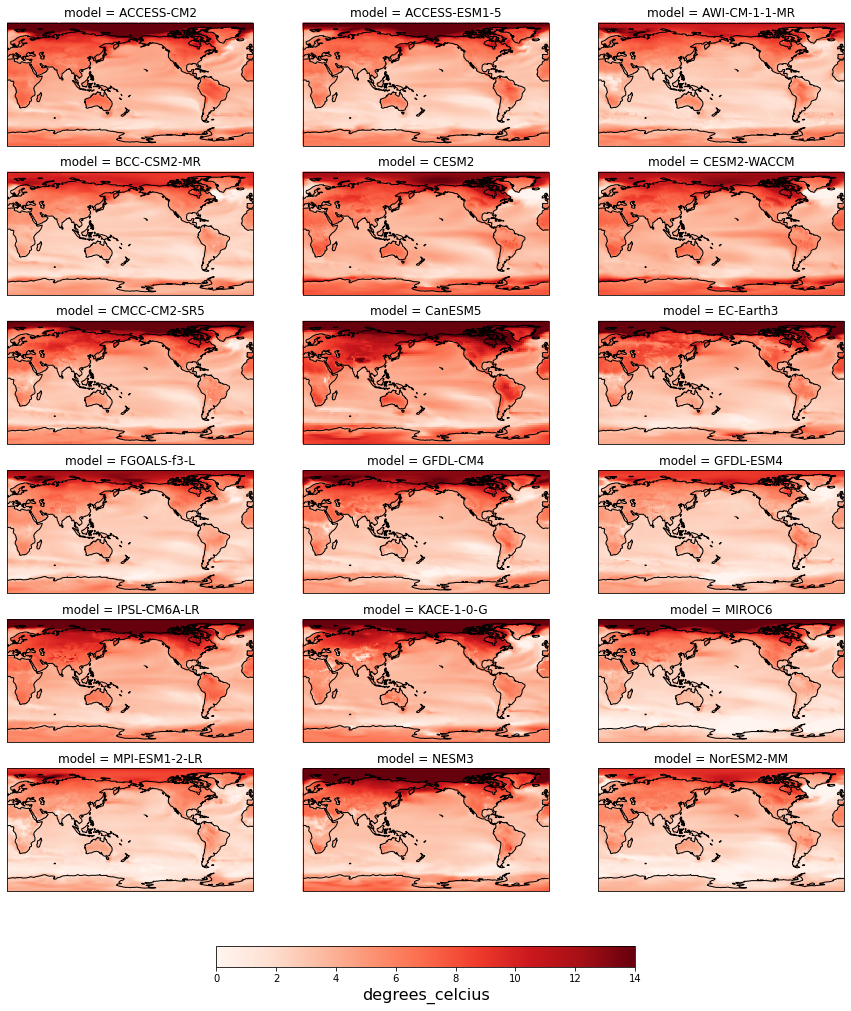

In [54]:
fig = plt.figure(figsize=(15,20))
axs = []

columns = 3
rows = 6

vmin = 0
vmax = 14

for i, m in enumerate(temp_diff.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = temp_diff.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='Reds')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('degrees_celcius', fontsize=16)

#plt.savefig('mean state changes temp.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

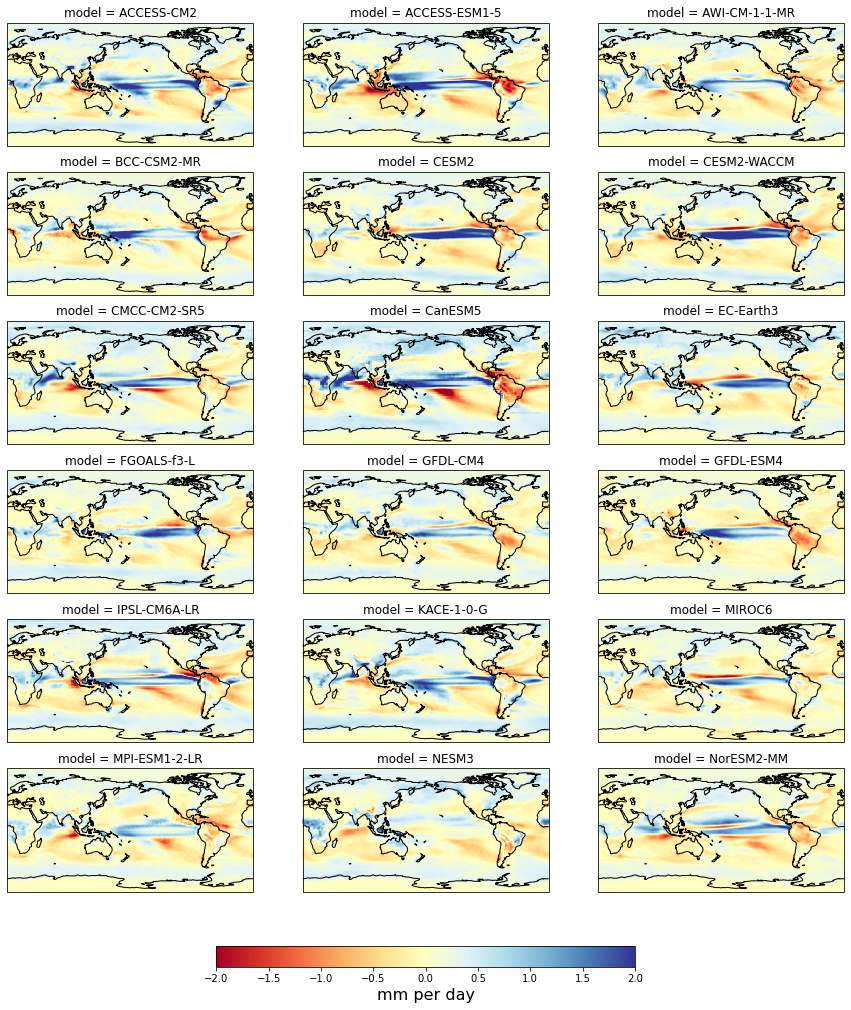

In [52]:
fig = plt.figure(figsize=(15,20))
axs = []

columns = 3
rows = 6

vmin = -2
vmax = 2

for i, m in enumerate(pr_diff.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pr_diff.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=16)

#plt.savefig('mean state changes pr.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

### Zonal Gradient of SST

In [55]:
zon_grad_hist_mmm = hist_temp_mmm.sel(lat=slice(-5,4)).sel(lon=slice(160, 270)).mean(dim='lat')
#zon_grad_hist_mmm.plot()

In [56]:
zon_grad_future_mmm = future_temp_mmm.sel(lat=slice(-5,4)).sel(lon=slice(160, 270)).mean(dim='lat')
#zon_grad_future_mmm.plot()

In [57]:
zon_grad_change_mmm = zon_grad_future_mmm - zon_grad_hist_mmm
#zon_grad_change_mmm.plot()

In [58]:
zon_grad_hist = hist_clim.sel(lat=slice(-5,5)).sel(lon=slice(160, 270)).mean(dim=['lat', 'time'])
zon_grad_future = future_clim.sel(lat=slice(-5,5)).sel(lon=slice(160, 270)).mean(dim=['lat', 'time'])
zon_grad_change = zon_grad_future - zon_grad_hist

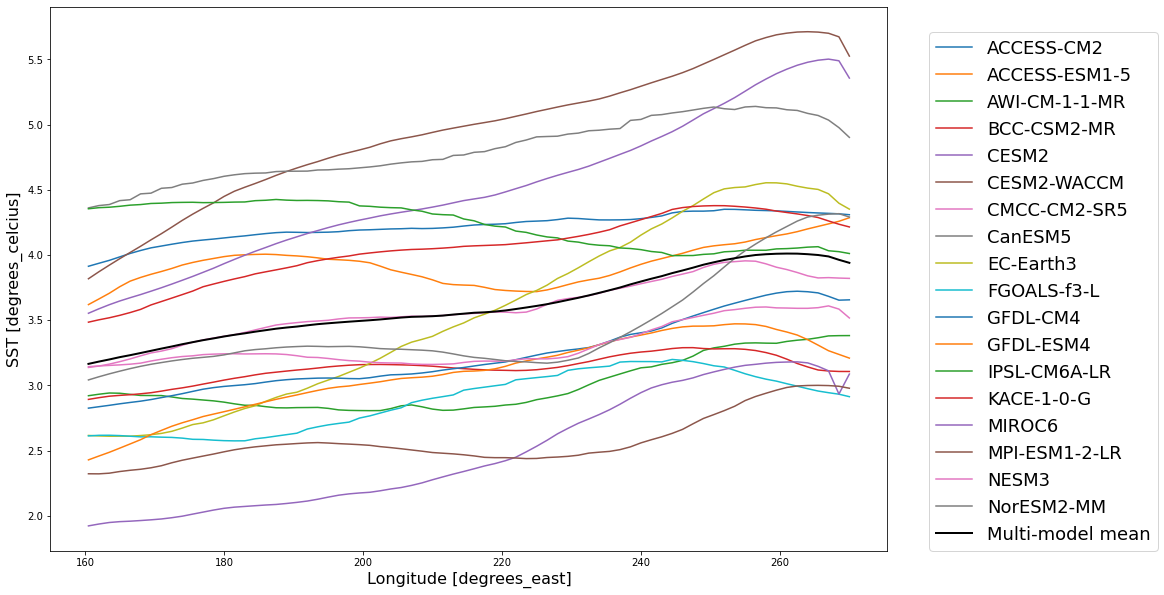

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
for m in zon_grad_change.model:
    zon_grad_change.sel(model=m).plot(ax=ax, label=f'{m.data}')
zon_grad_change_mmm.plot(ax=ax, color='black', linewidth='2', label='Multi-model mean')
lgd = plt.legend(loc=(1.05, 0), prop={'size': 18})
plt.xlabel('Longitude [degrees_east]', fontsize=16)
plt.ylabel('SST [degrees_celcius]', fontsize=16)

#plt.savefig('mean state changes zonal SST gradient.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

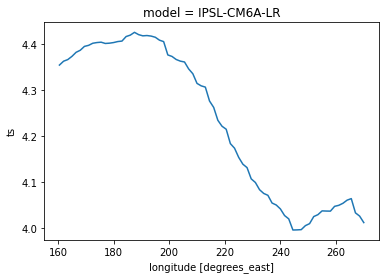

In [33]:
zon_grad_change.sel(model='IPSL-CM6A-LR').plot()